# Tile Rubin ECDFS (overlapping) and save per-tile center RA/Dec + WCS

In [1]:
import os, glob
import numpy as np
from lsst.daf.butler import Butler
import lsst.geom as geom

# ---- Config ----
OUT_RUBIN_DIR = "../data/rubin_tiles_ecdfs"
os.makedirs(OUT_RUBIN_DIR, exist_ok=True)

bands_rubin = ("u","g","r","i","z","y")
TILE_SIZE = 512
STRIDE    = 256    # overlap
MAX_TILES = None   # None => all tiles in that patch image

# ECDFS rough center (good enough to land on the right patch; you already validated visually)
ra_ecdfs  = 53.16
dec_ecdfs = -28.10

REPO="dp1"
COLLECTION="LSSTComCam/DP1"
DATASETTYPE="deep_coadd"


def get_one_deep_coadd_ref(butler, ra, dec, band, datasetType="deep_coadd"):
    refs = list(butler.query_datasets(
        datasetType,
        where="band.name = band AND patch.region OVERLAPS POINT(ra, dec)",
        bind={"band": band, "ra": ra, "dec": dec},
        with_dimension_records=True,
        order_by=["patch.tract"],
    ))
    if not refs:
        raise RuntimeError(f"No {datasetType} found for band={band} at ra,dec={ra},{dec}")
    return refs[0]


def load_patch_exposures(ra, dec, bands=bands_rubin, repo=REPO, collection=COLLECTION, datasetType=DATASETTYPE):
    butler = Butler(repo, collections=collection)
    ref0 = get_one_deep_coadd_ref(butler, ra, dec, bands[0], datasetType=datasetType)
    base_dataId = dict(ref0.dataId.mapping)

    exps = {}
    for b in bands:
        dataId = dict(base_dataId)
        dataId["band"] = b
        exps[b] = butler.get(datasetType, dataId=dataId)

    # full-patch WCS (pixel coords of the big coadd)
    wcs_full = exps[bands[0]].getWcs()
    return exps, wcs_full, base_dataId


def wcs_to_hdr_dict_lsst(wcs_lsst):
    md = wcs_lsst.getFitsMetadata()
    return {k: md.getScalar(k) for k in md.names()}


def tile_patch_and_save(exps, wcs_full, out_dir, tile_size=TILE_SIZE, stride=STRIDE, bands=bands_rubin, max_tiles=MAX_TILES):
    os.makedirs(out_dir, exist_ok=True)
    H, W = exps[bands[0]].image.array.shape
    n_saved = 0

    for y0 in range(0, H - tile_size + 1, stride):
        for x0 in range(0, W - tile_size + 1, stride):

            # local tile WCS: pixel (0,0) corresponds to (x0,y0) in full image
            wcs_local = wcs_full.copyAtShiftedPixelOrigin(geom.Extent2D(-x0, -y0))

            imgs, vars_, masks = [], [], []
            for b in bands:
                exp = exps[b]
                img = exp.image.array[y0:y0+tile_size, x0:x0+tile_size].astype(np.float32)
                var = exp.variance.array[y0:y0+tile_size, x0:x0+tile_size].astype(np.float32)
                msk = exp.mask.array[y0:y0+tile_size, x0:x0+tile_size].astype(np.int32)
                imgs.append(img); vars_.append(var); masks.append(msk)

            imgs  = np.stack(imgs,  axis=0)  # [6,512,512]
            vars_ = np.stack(vars_, axis=0)
            masks = np.stack(masks, axis=0)

            # tile center RA/Dec from LOCAL tile WCS
            cx, cy = (tile_size - 1)/2.0, (tile_size - 1)/2.0
            sp = wcs_local.pixelToSky(cx, cy)
            ra_c  = sp.getRa().asDegrees()
            dec_c = sp.getDec().asDegrees()

            tile_id = f"tile_x{x0:05d}_y{y0:05d}"
            fn = os.path.join(out_dir, f"{tile_id}.npz")

            np.savez_compressed(
                fn,
                img=imgs, var=vars_, mask=masks,
                wcs_hdr=wcs_to_hdr_dict_lsst(wcs_local),
                x0=np.int32(x0), y0=np.int32(y0),
                tile_id=np.bytes_(tile_id),
                ra_center=np.float64(ra_c), dec_center=np.float64(dec_c),
                tile_size=np.int32(tile_size), stride=np.int32(stride),
                bands=np.array(list(bands)),
            )

            n_saved += 1
            if (max_tiles is not None) and (n_saved >= max_tiles):
                return n_saved
    return n_saved


# ---- Run Rubin tiling for ECDFS ----
exps, wcs_full, dataId0 = load_patch_exposures(ra_ecdfs, dec_ecdfs)
print("[ECDFS] Using patch:", dataId0)

n = tile_patch_and_save(exps, wcs_full, out_dir=OUT_RUBIN_DIR)
print("Saved Rubin tiles:", n, "->", OUT_RUBIN_DIR)


[ECDFS] Using patch: {'band': 'u', 'skymap': 'lsst_cells_v1', 'tract': 5063, 'patch': 14}
Saved Rubin tiles: 144 -> ../data/rubin_tiles_ecdfs


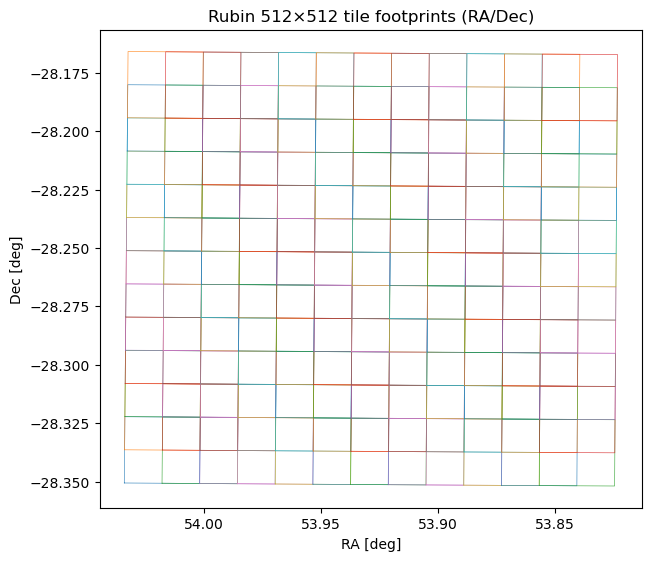

In [2]:
import lsst.afw.geom as afwGeom
from lsst.daf.base import PropertySet
import numpy as np
import glob
import matplotlib.pyplot as plt


def wcs_from_hdr_dict(hdr_dict):
    ps = PropertySet()
    for k, v in hdr_dict.items():
        ps.set(k, v)
    return afwGeom.makeSkyWcs(ps)


def tile_corners_from_npz(npz_path):
    d = np.load(npz_path, allow_pickle=True)

    wcs = wcs_from_hdr_dict(d["wcs_hdr"].item())
    tile_size = int(d["tile_size"])

    S = tile_size - 1
    corners_pix = [
        (0,   0),
        (S,   0),
        (S,   S),
        (0,   S),
        (0,   0),   # close polygon
    ]

    ra, dec = [], []
    for x, y in corners_pix:
        sp = wcs.pixelToSky(x, y)
        ra.append(sp.getRa().asDegrees())
        dec.append(sp.getDec().asDegrees())

    return np.array(ra), np.array(dec)

OUT_RUBIN_DIR = "../data/rubin_tiles_ecdfs"
files = sorted(glob.glob(f"{OUT_RUBIN_DIR}/tile_*.npz"))

plt.figure(figsize=(7,7))

for fn in files:
    ra, dec = tile_corners_from_npz(fn)
    plt.plot(ra, dec, linewidth=0.5, alpha=0.8)

plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("Rubin 512×512 tile footprints (RA/Dec)")

# astronomy convention
plt.gca().invert_xaxis()
plt.gca().set_aspect("equal", adjustable="box")

plt.show()


# For each Rubin tile, fetch Euclid VIS + Y/J/H and save with the same tile_id

In [12]:
import os, glob
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
from astropy.nddata import Cutout2D
from astroquery.ipac.irsa import Irsa
import fsspec
from tqdm.auto import tqdm
import lsst.afw.geom as afwGeom
from lsst.daf.base import PropertySet

OUT_RUBIN_DIR = "../data/rubin_tiles_ecdfs"
OUT_EUCLID_VIS  = "../data/euclid_tiles_VIS"
OUT_EUCLID_NISP = "../data/euclid_tiles_NISP"
os.makedirs(OUT_EUCLID_VIS,  exist_ok=True)
os.makedirs(OUT_EUCLID_NISP, exist_ok=True)

EUCLID_COLLECTION = "euclid_DpdMerBksMosaic"
RADIUS_ARCSEC = 180
SIZE_ARCSEC   = 102.4  # ~512 * 0.2"


def wcs_from_lsst_hdr(hdr_dict):
    ps = PropertySet()
    for k, v in hdr_dict.items():
        ps.set(k, v)
    return afwGeom.makeSkyWcs(ps)


def wcs_to_hdr_dict_astropy(wcs: WCS) -> dict:
    hdr = wcs.to_header(relax=True)
    return {k: hdr[k] for k in hdr.keys()}


def load_euclid_cutouts_one_query(
    ra, dec, size_arcsec,
    bands=("VIS","Y","J","H"),
    collection=EUCLID_COLLECTION,
    radius_arcsec=RADIUS_ARCSEC,
    min_margin_pix=300,
    fill_value=np.nan,
):
    coord_use = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame="icrs")

    q = Irsa.query_sia(pos=(coord_use, radius_arcsec*u.arcsec), collection=collection)
    tab = q.to_table() if hasattr(q, "to_table") else q
    if len(tab) == 0:
        return {b: None for b in bands}, {}, coord_use

    if "dataproduct_subtype" in tab.colnames:
        tab = tab[tab["dataproduct_subtype"] == "science"]
    if len(tab) == 0:
        return {b: None for b in bands}, {}, coord_use

    out = {b: None for b in bands}
    wcs_out = {}

    def pick_row_with_margin(rows, coord):
        # prefer rows where coord lands well inside the parent image
        for row in rows:
            url = row["access_url"]
            try:
                with fsspec.open(url, "rb") as fh:
                    with fits.open(fh, memmap=False) as hdul:
                        w = WCS(hdul[0].header)
                        H, W_ = hdul[0].data.shape
                        x, y = w.world_to_pixel(coord)
                        if (min_margin_pix <= x <= W_-1-min_margin_pix and
                            min_margin_pix <= y <= H-1-min_margin_pix):
                            return row
            except Exception:
                continue
        return rows[0]  # fallback

    for b in bands:
        rows = tab
        if "energy_bandpassname" in tab.colnames:
            rows = tab[tab["energy_bandpassname"] == b]
        if len(rows) == 0:
            continue

        row = pick_row_with_margin(rows, coord_use)
        url = row["access_url"]

        with fsspec.open(url, "rb") as fh:
            with fits.open(fh, memmap=False) as hdul:
                wcs0 = WCS(hdul[0].header)

                # ✅ FIX 1: always produce a cutout centered on coord_use (pad if near edge)
                cut = Cutout2D(
                    hdul[0].data,
                    coord_use,
                    size_arcsec*u.arcsec,
                    wcs=wcs0,
                    mode="partial",
                    fill_value=fill_value,
                )
                out[b] = np.array(cut.data, dtype=np.float32)
                wcs_out[b] = cut.wcs

    return out, wcs_out, coord_use


def make_euclid_tiles_from_rubin_tiles(
    rubin_dir,
    out_vis_dir=OUT_EUCLID_VIS,
    out_nisp_dir=OUT_EUCLID_NISP,
    size_arcsec=SIZE_ARCSEC,
    collection=EUCLID_COLLECTION,
    radius_arcsec=RADIUS_ARCSEC,
    resume=True,
):
    rubin_files = sorted(glob.glob(os.path.join(rubin_dir, "*.npz")))
    if not rubin_files:
        raise ValueError(f"No Rubin NPZ tiles found in {rubin_dir}")

    n_vis, n_nisp = 0, 0

    for rpath in tqdm(rubin_files, desc="ECDFS: fetching Euclid cutouts", unit="tile"):
        tile_id = os.path.splitext(os.path.basename(rpath))[0]
        vis_path  = os.path.join(out_vis_dir,  f"{tile_id}.npz")
        nisp_path = os.path.join(out_nisp_dir, f"{tile_id}.npz")

        if resume and os.path.exists(vis_path) and os.path.exists(nisp_path):
            continue

        f = np.load(rpath, allow_pickle=True)

        # Rubin tile center from Rubin tile WCS
        wcs_tile = wcs_from_lsst_hdr(f["wcs_hdr"].item())
        tile_size = int(f["tile_size"])
        cx = (tile_size - 1) / 2.0
        cy = (tile_size - 1) / 2.0
        sp = wcs_tile.pixelToSky(cx, cy)
        ra = sp.getRa().asDegrees()
        dec = sp.getDec().asDegrees()

        out, wcs_out, coord_use = load_euclid_cutouts_one_query(
            ra, dec, size_arcsec,
            bands=("VIS","Y","J","H"),
            collection=collection,
            radius_arcsec=radius_arcsec,
        )

        ra_use  = float(coord_use.ra.deg)
        dec_use = float(coord_use.dec.deg)

        # --- VIS ---
        vis = out.get("VIS")
        if vis is None:
            vis_img = np.zeros((1, 1, 1), dtype=np.float32)
            vis_valid = np.zeros((1, 1, 1), dtype=np.uint8)
            vis_hdr = {}
        else:
            vis_img = vis[None, ...].astype(np.float32)  # [1,H,W]
            vis_valid = np.ones_like(vis_img, dtype=np.uint8)
            vis_hdr = wcs_to_hdr_dict_astropy(wcs_out["VIS"])
            n_vis += 1

        np.savez_compressed(
            vis_path,
            img=vis_img,
            valid=vis_valid,
            wcs_hdr=vis_hdr,
            ra_center=np.float64(ra),
            dec_center=np.float64(dec),
            ra_used=np.float64(ra_use),
            dec_used=np.float64(dec_use),
            size_arcsec=np.float32(size_arcsec),
            tile_id=np.bytes_(tile_id),
            source_rubin=np.bytes_(rpath),
        )

        # --- NISP Y/J/H ---
        nisp_imgs, nisp_valid, nisp_hdrs = [], [], []
        for b in ("Y","J","H"):
            im = out.get(b)
            if im is None:
                nisp_imgs.append(np.zeros((1,1), dtype=np.float32))
                nisp_valid.append(np.zeros((1,1), dtype=np.uint8))
                nisp_hdrs.append({})
            else:
                nisp_imgs.append(im.astype(np.float32))
                nisp_valid.append(np.ones_like(im, dtype=np.uint8))
                nisp_hdrs.append(wcs_to_hdr_dict_astropy(wcs_out[b]))

        Hmax = max(im.shape[0] for im in nisp_imgs)
        Wmax = max(im.shape[1] for im in nisp_imgs)

        def pad_to(arr, H, W, fill=0):
            outa = np.full((H, W), fill, dtype=arr.dtype)
            h, w = arr.shape
            outa[:h, :w] = arr
            return outa

        nisp_imgs  = np.stack([pad_to(im, Hmax, Wmax, 0) for im in nisp_imgs], axis=0)    # [3,H,W]
        nisp_valid = np.stack([pad_to(vm, Hmax, Wmax, 0) for vm in nisp_valid], axis=0)  # [3,H,W]

        if any(v.mean() > 0 for v in nisp_valid):
            n_nisp += 1

        np.savez_compressed(
            nisp_path,
            img=nisp_imgs,
            valid=nisp_valid,
            wcs_hdr=nisp_hdrs,
            bands=np.array(["Y","J","H"]),
            ra_center=np.float64(ra),
            dec_center=np.float64(dec),
            ra_used=np.float64(ra_use),
            dec_used=np.float64(dec_use),
            size_arcsec=np.float32(size_arcsec),
            tile_id=np.bytes_(tile_id),
            source_rubin=np.bytes_(rpath),
        )

    print(f"Done. Euclid VIS written for all tiles (non-empty count={n_vis}). "
          f"NISP written for all tiles (non-empty count={n_nisp}).")


# run
# make_euclid_tiles_from_rubin_tiles(OUT_RUBIN_DIR, resume=True)


In [13]:

rpath = "../data/rubin_tiles_ecdfs/tile_x00000_y01280.npz"
r = np.load(rpath, allow_pickle=True)

wcs_tile = wcs_from_lsst_hdr(r["wcs_hdr"].item())
S = int(r["tile_size"])
cx = (S - 1) / 2.0
cy = (S - 1) / 2.0
sp = wcs_tile.pixelToSky(cx, cy)

ra = sp.getRa().asDegrees()
dec = sp.getDec().asDegrees()

print("Rubin WCS center:", ra, dec)


Rubin WCS center: 54.017394251608735 -28.265443674097867


In [ ]:
out, wcs_out, coord_use = load_euclid_cutouts_one_query(
    ra, dec, SIZE_ARCSEC,
    bands=("VIS","Y","J","H")
)


In [ ]:
from astropy.wcs.utils import skycoord_to_pixel

vis = out["VIS"]
w = wcs_out["VIS"]

x, y = skycoord_to_pixel(coord_use, w)
H, W = vis.shape

print("VIS shape:", (H, W))
print("Pixel of Rubin center:", x, y)
print("Expected center:", (W-1)/2, (H-1)/2)
print("Offset (pix):", x-(W-1)/2, y-(H-1)/2)

import matplotlib.pyplot as plt

plt.imshow(vis, origin="lower", cmap="gray")
plt.scatter(x, y, s=100, facecolors="none", edgecolors="r")
plt.title("Red circle = Rubin tile center in Euclid VIS")
plt.show()


# Final Dataset: always returns Rubin(6) + VIS(1) + NISP(3) = 10 channels, plus validity masks

In [ ]:
import os, glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

bands_rubin  = ["u","g","r","i","z","y"]
bands_euclid_vis  = ["VIS"]
bands_euclid_nisp = ["Y","J","H"]

class ECDFSCrossSurveyDataset(Dataset):
    def __init__(self, rubin_dir, euclid_vis_dir, euclid_nisp_dir):
        self.rubin_dir = rubin_dir
        self.euclid_vis_dir = euclid_vis_dir
        self.euclid_nisp_dir = euclid_nisp_dir

        self.rubin_files = sorted(glob.glob(os.path.join(rubin_dir, "*.npz")))
        if not self.rubin_files:
            raise ValueError(f"No Rubin tiles found in {rubin_dir}")

        # index by tile_id (basename)
        self.tile_ids = [os.path.splitext(os.path.basename(p))[0] for p in self.rubin_files]

    def __len__(self):
        return len(self.tile_ids)

    def __getitem__(self, idx):
        tile_id = self.tile_ids[idx]

        # --- Rubin ---
        r = np.load(os.path.join(self.rubin_dir, f"{tile_id}.npz"), allow_pickle=True)
        rubin_img  = torch.from_numpy(r["img"]).float()   # [6,512,512]
        rubin_var  = torch.from_numpy(r["var"]).float()
        rubin_mask = torch.from_numpy(r["mask"]).int()
        ra = float(r["ra_center"]); dec = float(r["dec_center"])

        # --- Euclid VIS ---
        vpath = os.path.join(self.euclid_vis_dir, f"{tile_id}.npz")
        v = np.load(vpath, allow_pickle=True) if os.path.exists(vpath) else None
        if v is None:
            vis_img = torch.zeros((1,1,1), dtype=torch.float32)
            vis_valid = torch.zeros((1,1,1), dtype=torch.uint8)
        else:
            vis_img = torch.from_numpy(v["img"]).float()          # [1,H,W]
            vis_valid = torch.from_numpy(v["valid"]).to(torch.uint8)

        # --- Euclid NISP ---
        npath = os.path.join(self.euclid_nisp_dir, f"{tile_id}.npz")
        n = np.load(npath, allow_pickle=True) if os.path.exists(npath) else None
        if n is None:
            nisp_img = torch.zeros((3,1,1), dtype=torch.float32)
            nisp_valid = torch.zeros((3,1,1), dtype=torch.uint8)
        else:
            nisp_img = torch.from_numpy(n["img"]).float()         # [3,H,W]
            nisp_valid = torch.from_numpy(n["valid"]).to(torch.uint8)

        return {
            "tile_id": tile_id,
            "ra_center": ra,
            "dec_center": dec,
            "rubin": {
                "img": rubin_img, "var": rubin_var, "mask": rubin_mask,
                "bands": bands_rubin,
            },
            "euclid_vis": {
                "img": vis_img, "valid": vis_valid, "bands": bands_euclid_vis,
            },
            "euclid_nisp": {
                "img": nisp_img, "valid": nisp_valid, "bands": bands_euclid_nisp,
            },
        }

# --- usage ---
ds = ECDFSCrossSurveyDataset(
    rubin_dir="../data/cross_survey/ECDFS/rubin_tiles",
    euclid_vis_dir="../data/cross_survey/ECDFS/euclid_tiles_VIS",
    euclid_nisp_dir="../data/cross_survey/ECDFS/euclid_tiles_NISP",
)
dl = DataLoader(ds, batch_size=2, shuffle=True, num_workers=2)

batch = next(iter(dl))
print("Batch tile_ids:", batch["tile_id"])
print("Rubin:", batch["rubin"]["img"].shape)
print("Euclid VIS:", batch["euclid_vis"]["img"].shape)
print("Euclid NISP:", batch["euclid_nisp"]["img"].shape)
